# Import Packages

In [8]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import numpy as np
import cv2
import glob
%matplotlib inline

In [114]:
images = glob.glob('../test_images/*.jpg')
images.sort()
#images = images[0:3]
print(images)


def save_binary_image(binary):
    save_img = binary.copy()
    save_img[save_img == 1] = 255
    return save_img

['../test_images/straight_lines1.jpg', '../test_images/straight_lines2.jpg', '../test_images/test1.jpg', '../test_images/test2.jpg', '../test_images/test3.jpg', '../test_images/test4.jpg', '../test_images/test5.jpg', '../test_images/test6.jpg']


../test_images/straight_lines1.jpg
../test_images/straight_lines2.jpg
../test_images/test1.jpg
../test_images/test2.jpg
../test_images/test3.jpg
../test_images/test4.jpg
../test_images/test5.jpg
../test_images/test6.jpg


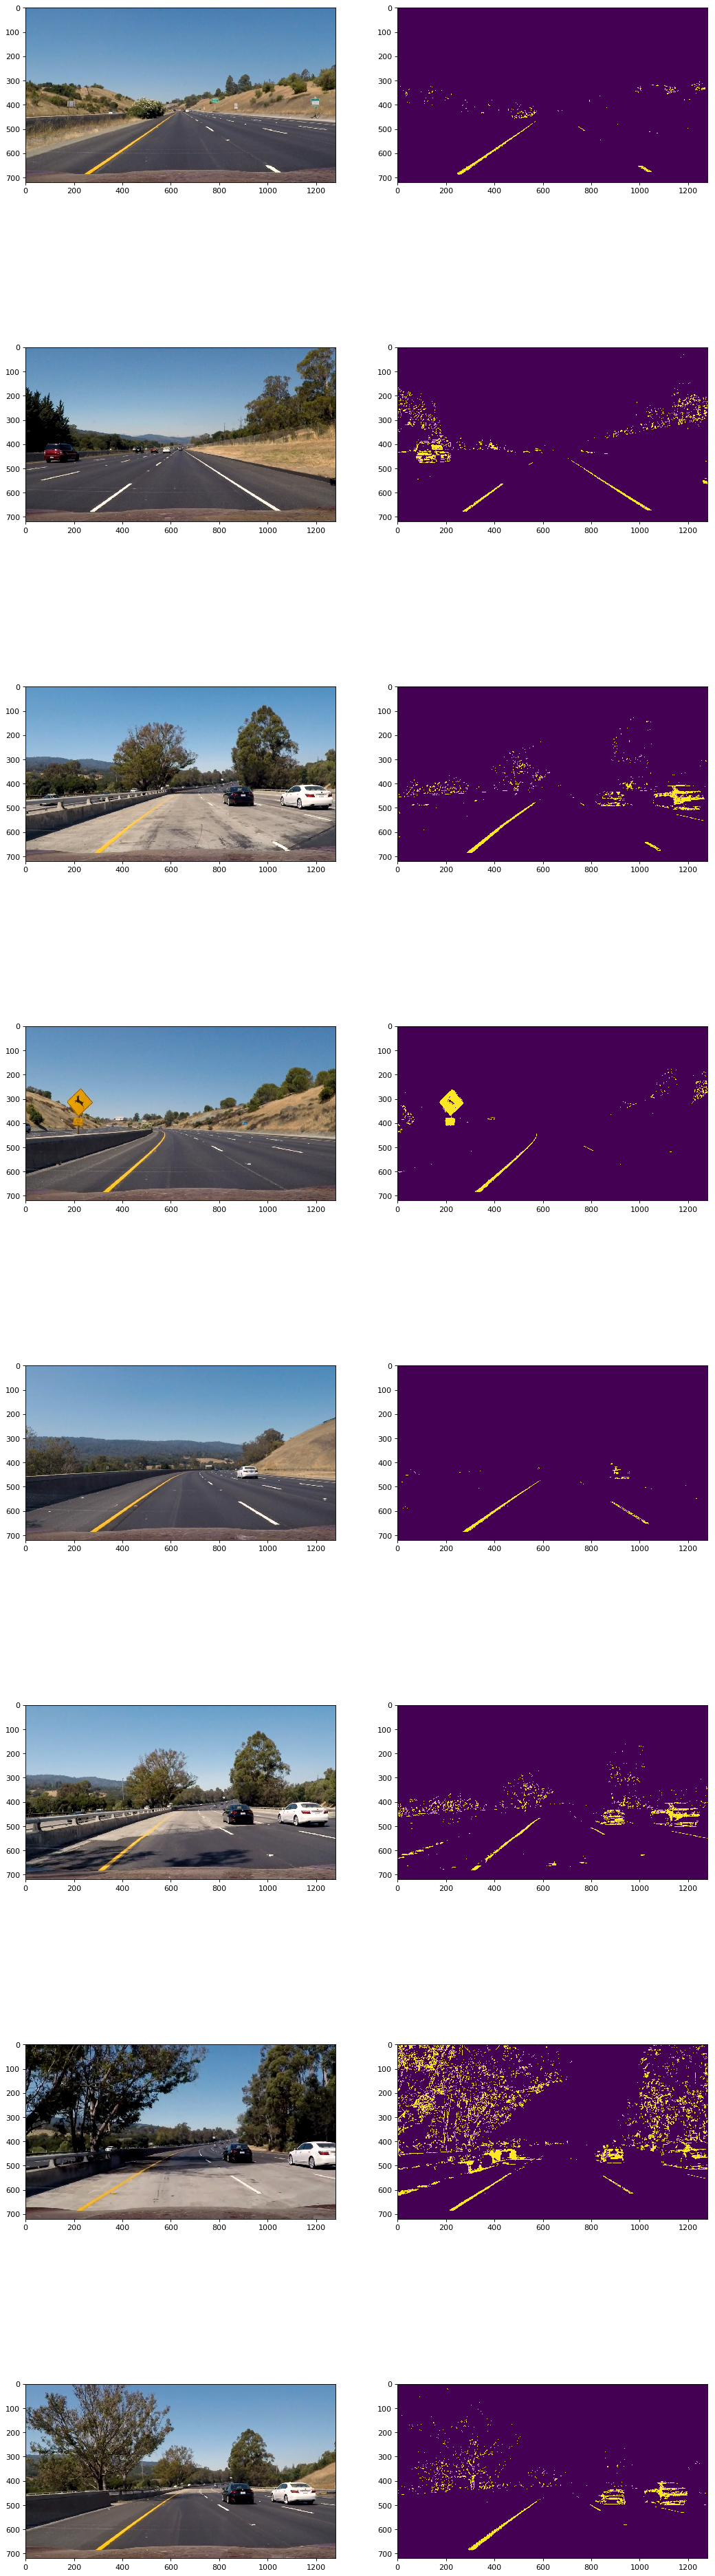

In [112]:
sobel_thresh_min = 20
sobel_thresh_max = 100
sobel_kernel_size = 7

s_thresh_min = 170
s_thresh_max = 255

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobel_x **2 + sobel_y ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary = np.zeros_like(scaled)
    binary[(mag_thresh[0] <= scaled) & (scaled <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = binary
    return binary_output

def make_s_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary
    
def make_binary_image(img):
    
    sobel = mag_thresh(img, sobel_kernel=sobel_kernel_size, mag_thresh=(sobel_thresh_min, sobel_thresh_max))
    s_binary = make_s_thresh(img, thresh=(s_thresh_min, s_thresh_max))
    
    return s_binary


binary_images = []
plt.figure(figsize=(16, 64),dpi=80)
for i, path in enumerate(images): 
    output_dir = "../output_images/binary_images"
    prefix = "".join(path.split("/")[:-2])
    fname = path.split("/")[-1]
    img = mpimg.imread(path)

    result_img = make_binary_image(img)
    binary_images.append(result_img)
    
    cv2.imwrite("{}/{}".format(output_dir, fname), save_binary_image(result_img))
    print(path)
    
    plt.subplot(len(images), 2, 2*i+ 1)
    plt.imshow(img)
    plt.subplot(len(images), 2, 2*i+2)
    plt.imshow(result_img)
    
    
    

../test_images/straight_lines1.jpg
../test_images/straight_lines2.jpg
../test_images/test1.jpg
../test_images/test2.jpg
../test_images/test3.jpg
../test_images/test4.jpg
../test_images/test5.jpg
../test_images/test6.jpg


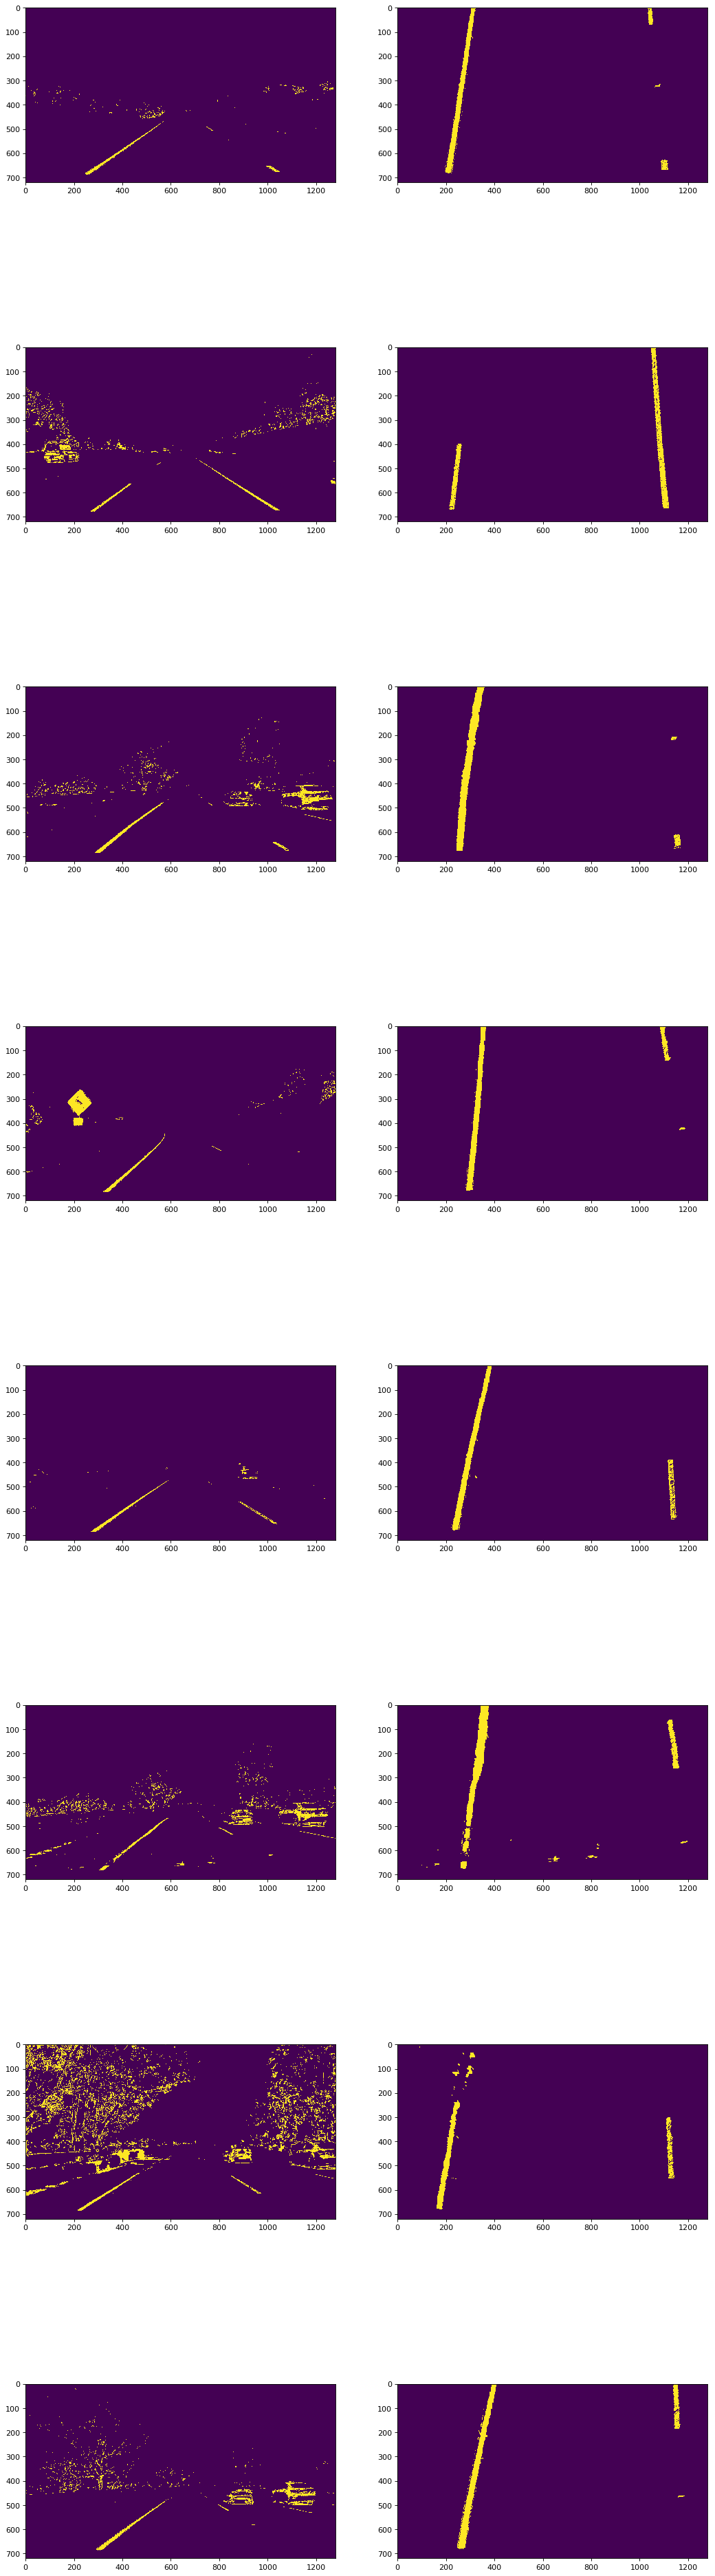

In [116]:

def make_perspective_image(img):
    # ld, lu, ru, rd
    #src = np.float32([[0, 720],  [580, 450], [700, 450], [1280, 720]])
    #dst = np.float32([[0, 720],  [  50,   0], [1230,  0], [1280, 720]])
    src = np.float32([[0, 720],  [440, 500], [840, 500], [1280, 720]])
    dst = np.float32([[0, 720],  [  50,   0], [1280,  0], [1280, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (1280, 720))
    return warped

warped_images = []

plt.figure(figsize=(16, 64),dpi=80)
for i, path in enumerate(images):
    output_dir = "../output_images/perspective_images"
    prefix = "".join(path.split("/")[:-2])
    fname = path.split("/")[-1]
    img = binary_images[i]
    
    result_img = make_perspective_image(img)
    warped_images.append(result_img)
    
    
    cv2.imwrite("{}/{}".format(output_dir, fname), save_binary_image(result_img))
    print(path)
    
    plt.subplot(len(images), 2, 2*i+ 1)
    plt.imshow(img)
    plt.subplot(len(images), 2, 2*i+2)
    plt.imshow(result_img)
    

../test_images/straight_lines1.jpg
../test_images/straight_lines2.jpg
../test_images/test1.jpg
../test_images/test2.jpg
../test_images/test3.jpg
../test_images/test4.jpg
../test_images/test5.jpg
../test_images/test6.jpg


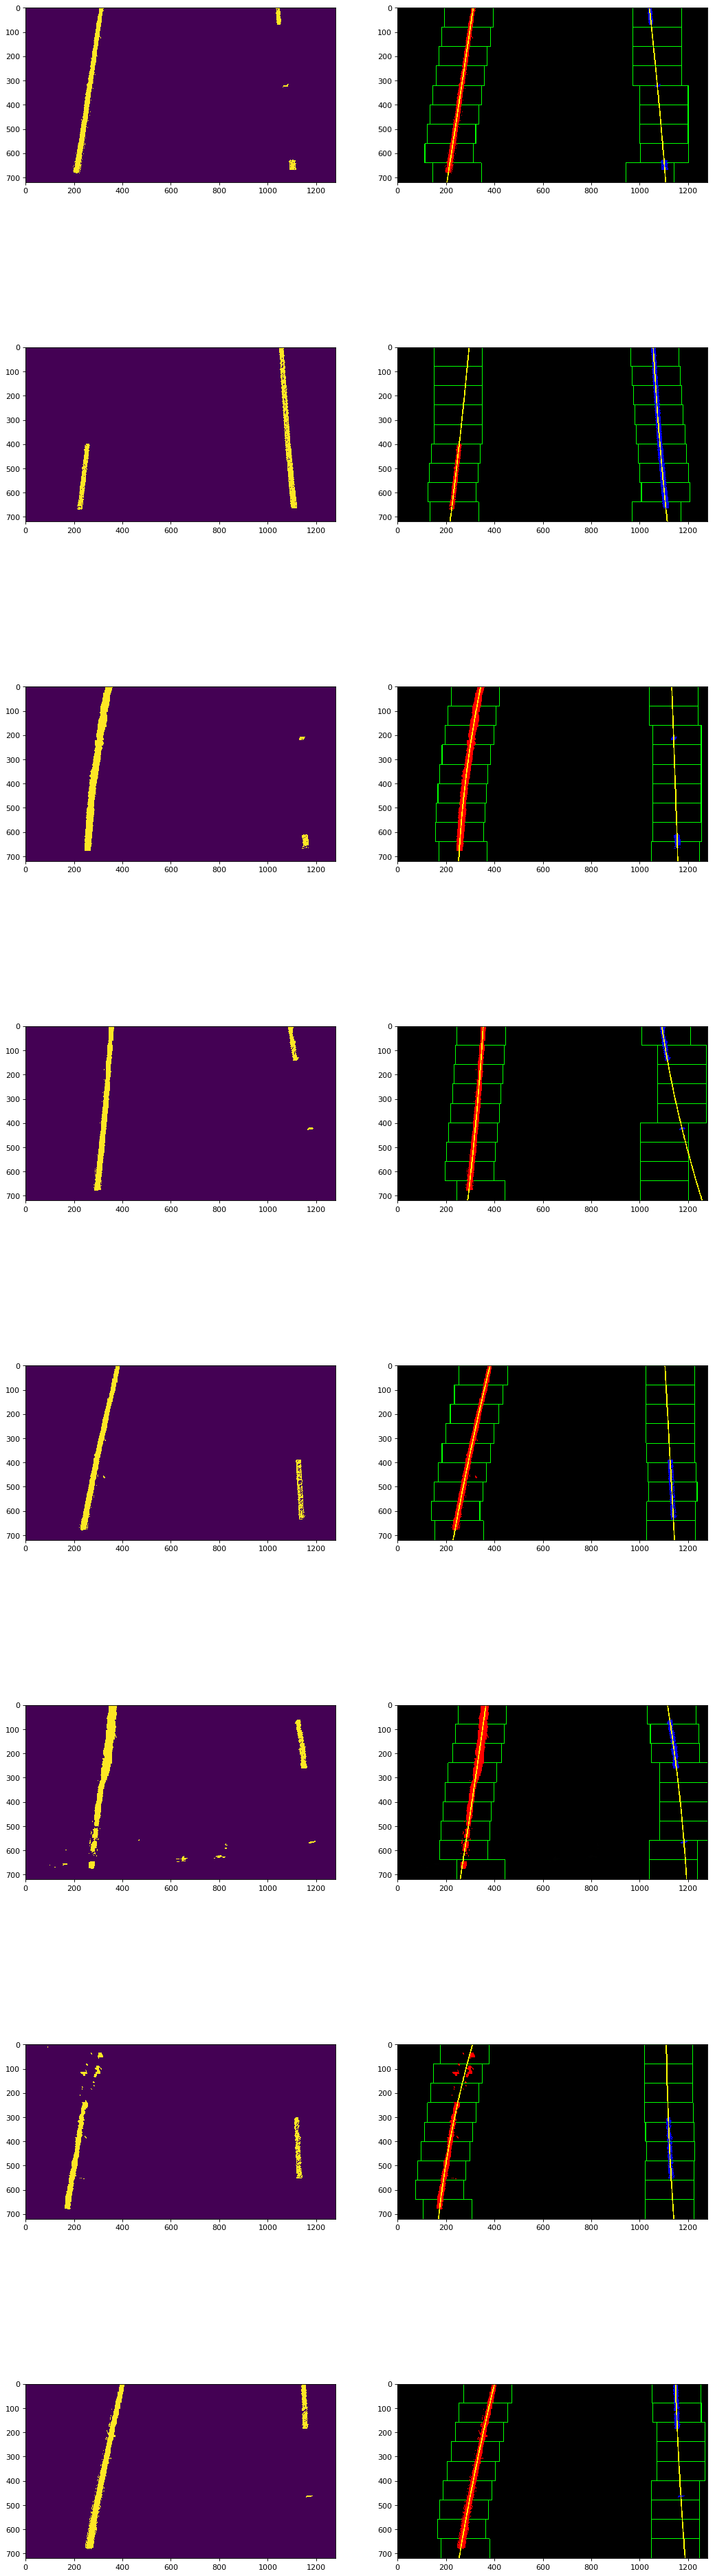

In [183]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = np.sum(binary_warped[:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if nonzerox[good_left_inds].size > minpix:
            leftx_current = np.int(nonzerox[good_left_inds].mean())
        if nonzerox[good_right_inds].size > minpix:
            rightx_current = np.int(nonzerox[good_right_inds].mean())

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit =np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    pts = np.array(list(zip(left_fitx, ploty)), dtype=np.int32)
    cv2.polylines(out_img, [pts], isClosed=False, color=(255, 255, 0), thickness=3)

    pts = np.array(list(zip(right_fitx, ploty)), dtype=np.int32)
    cv2.polylines(out_img, [pts], isClosed=False, color=(255, 255, 0), thickness=3)
    
    return out_img, left_fit, right_fit

def make_polyfit_image(img):
    out_img = fit_polynomial(img)
    return out_img

plt.figure(figsize=(16, 64),dpi=80)

polyfit_images = []
left_fits = []
right_fits = []

for i, path in enumerate(images):
    output_dir = "../output_images/polyfit_images"
    prefix = "".join(path.split("/")[:-2])
    fname = path.split("/")[-1]
    img = warped_images[i]
    
    
    result_img, left_fit, right_fit = make_polyfit_image(img)
    polyfit_images.append(result_img)
    left_fits.append(left_fit)
    right_fits.append(right_fit)

    cv2.imwrite("{}/{}".format(output_dir, fname), result_img)
    print(path)
    
    plt.subplot(len(images), 2, 2*i+ 1)
    plt.imshow(img)
    plt.subplot(len(images), 2, 2*i+2)
    plt.imshow(result_img)

